In [1]:
%reload_ext autoreload
%autoreload 2

import os
import argparse
import sys
from time import time
import cv2

from joblib import Parallel, delayed

sys.path.append(os.path.join(os.environ['GORDON_REPO_DIR'], 'utilities'))
from utilities2015 import *

from matplotlib.path import Path
%matplotlib inline

import scipy.ndimage as nd
import scipy

from skimage.feature import hog
from skimage import data, color, exposure
from sklearn.cluster import KMeans
from sklearn import svm
from sklearn.metrics import confusion_matrix

import random

In [2]:
X = np.load('/oasis/projects/nsf/csd395/ruogu/svm2/X.npy');
y = np.load('/oasis/projects/nsf/csd395/ruogu/svm2/y.npy');

In [3]:
print "%s" %(X.shape,);
print "%s" %(y.shape,);

(188118, 4200)
(188118,)


In [4]:
raw_data = zip(X, y);
print type(raw_data);

<type 'list'>


In [10]:
data = [];
n_classSample = 100; # Number of samples from each class
for i in range(0, 10):
    data_for_class = [x for x in raw_data if x[1] == i];
    data = data + random.sample(data_for_class, n_classSample);
# data is a list of (ndarray, int)
random.shuffle(data);

In [11]:
quota = 0.75;
n_training = int(len(data) * quota);
n_testing = len(data) - n_training;

In [12]:
training_data = data[:n_training];
testing_data = data[n_training:];

In [13]:
training_X = np.asarray([x[0] for x in training_data]);
training_y = np.asarray([x[1] for x in training_data]);
testing_X = np.asarray([x[0] for x in testing_data]);
testing_y = np.asarray([x[1] for x in testing_data]);

In [14]:
print "Shape of training data: %s" %(training_X.shape,);
print "Shape of training label: %s" %(training_y.shape,);
print "Shape of testing data: %s" %(testing_X.shape,);
print "Shape of testing label: %s" %(testing_y.shape,);

Shape of training data: (750, 4200)
Shape of training label: (750,)
Shape of testing data: (250, 4200)
Shape of testing label: (250,)


In [16]:
# Calculate histogram intersection kernel
start = time();
myKernel = np.zeros(shape=(n_training, n_training));
for i in range(0, n_training):
    for j in range(0, n_training):
        myKernel[i][j] = 0.5 * sum(training_X[i] + training_X[j] - np.absolute(training_X[i] - training_X[j]));
end = time();
print "Kernel calculation takes {} sec.".format(end - start);

Kernel calculation takes 289.851194859 sec.


In [17]:
print "kernel shape: %s" %(myKernel.shape,);

kernel shape: (750, 750)


In [18]:
# Train SVM
clf = svm.SVC(kernel="precomputed", decision_function_shape='ovr');
clf.fit(myKernel, training_y);

In [20]:
# Training accuracy
predict_labels_train = clf.predict(myKernel);
n_correct_train = 0;
for i in range(len(training_data)):
    if predict_labels_train[i] == training_y[i]:
        n_correct_train += 1;
print "Training accuracy: {}".format(1.0*n_correct_train / len(training_data));

Training accuracy: 0.978666666667


In [21]:
cm_train = confusion_matrix(training_y, predict_labels_train);

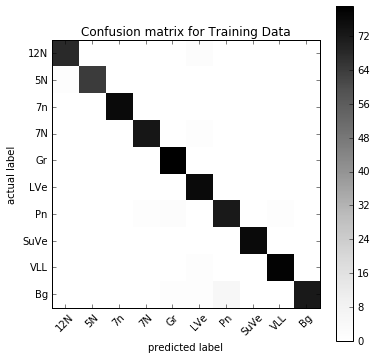

In [22]:
plt.figure(figsize=(6, 6));
plt.imshow(cm_train, interpolation='nearest', cmap=plt.cm.Greys);
plt.ylabel('actual label');
plt.xlabel('predicted label')
plt.title('Confusion matrix for Training Data');
plt.colorbar();
classes = ['12N', '5N', '7n', '7N', 'Gr', 'LVe', 'Pn', 'SuVe', 'VLL', 'Bg'];
tick_marks = np.arange(len(classes));
plt.xticks(tick_marks, classes, rotation=45);
plt.yticks(tick_marks, classes);

In [23]:
# Test
testKernel = np.zeros(shape=(n_testing, n_training));
for i in range(0, n_testing):
    for j in range(0, n_training):
        testKernel[i][j] = 0.5*sum(testing_X[i] + training_X[j] - np.absolute(testing_X[i] - training_X[j]));

In [24]:
predict_labels_test = clf.predict(testKernel);
n_correct_test = 0;
for i in range(0, n_testing):
    if (predict_labels_test[i] == testing_y[i]):
        n_correct_test += 1;
print "Test accuracy: {}".format(1.0*n_correct_test / n_testing);

Test accuracy: 0.468


In [25]:
cm_test = confusion_matrix(testing_y, predict_labels_test);

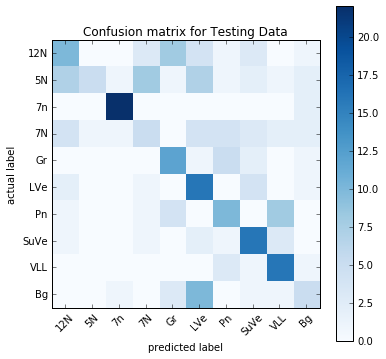

In [26]:
plt.figure(figsize=(6, 6));
plt.imshow(cm_test, interpolation='nearest', cmap=plt.cm.Blues);
plt.ylabel('actual label');
plt.xlabel('predicted label')
plt.title('Confusion matrix for Testing Data');
plt.colorbar();
classes = ['12N', '5N', '7n', '7N', 'Gr', 'LVe', 'Pn', 'SuVe', 'VLL', 'Bg'];
tick_marks = np.arange(len(classes));
plt.xticks(tick_marks, classes, rotation=45);
plt.yticks(tick_marks, classes);

In [27]:
class Classifier:
    classes = ['12N', '5N', '7n', '7N', 'Gr', 'LVe', 'Pn', 'SuVe', 'VLL', 'Bg'];
    def __init__(self, training_X, clf, vocabulary):
        self.training_X = training_X;
        self.clf = clf;
        self.vocabulary = vocabulary;
    
    def generateKernel(self, test_X):
        n_testing = test_X.shape[0];
        n_training = self.training_X.shape[0];
        testKernel = np.zeros(shape=(n_testing, n_training));
        for i in range(0, n_testing):
            for j in range(0, n_training):
                testKernel[i][j] = sum(np.minimum(test_X[i], self.training_X[j]));
        return testKernel;
    
    def getHistogram(self, image, kmeans, M, L):
        x_size = image.shape[1]; # Column
        y_size = image.shape[0]; # Row
        # Get SIFT key points and descriptor.
        sift = cv2.SIFT();
        key_points, descriptor = sift.detectAndCompute(image, None);
        # Map key points with type.
        if descriptor is None:
            return None;
        cluster_labels = kmeans.predict(descriptor);
        cluster_labels = cluster_labels;
        # Generate position list of key_points
        positions = np.asarray([kp.pt for kp in key_points], np.int)
        # Level 0
        weight_0 = 1.0 / (2**L);
        histogram = np.bincount(cluster_labels, minlength = M);
        histogram = histogram * weight_0;
        # Other levels
        for l in range(1, L + 1):
            weight = 1.0 / (2**(L - l + 1));
            grid_size_x = x_size / (2**l);
            grid_size_y = y_size / (2**l);
            grid_boundaries_x = range(0, x_size, grid_size_x);
            grid_boundaries_y = range(0, y_size, grid_size_y);
            number_of_grid = (2**l)**2;
            grid_crs = positions / [grid_size_x, grid_size_y];
            grid_cols = grid_crs[:,0];  # x
            grid_rows = grid_crs[:,1];  # y
    
            keypoint_grid_indices = grid_rows * (2**l) + grid_cols;
            hists = np.zeros(shape=(number_of_grid, M), dtype=np.int);
            for ki, label in zip(keypoint_grid_indices, cluster_labels):
                hists[ki][label] += 1;
            hists = hists * weight;
            histogram = np.hstack((histogram, hists.flatten()));
        return (histogram / len(key_points)); # Normalization

    def predictLabel(self, image):
        M = self.vocabulary.shape[0];
        L = 2;
        kmeans = KMeans(init='random', n_clusters=M, n_init=10);
        kmeans.fit(self.vocabulary);
        img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY);
        histogram = self.getHistogram(img, kmeans, M, L);
        if histogram is None:
            return 'Bg';
        testKernel = self.generateKernel(np.asarray(histogram).reshape(1, histogram.shape[0]));
        return Classifier.classes[self.clf.predict(testKernel)[0]];

In [28]:
vocabulary = np.load('/oasis/projects/nsf/csd395/ruogu/vocabulary/vocabulary.npy');

In [29]:
myClassifier = Classifier(training_X, clf, vocabulary);

In [30]:
import pickle
pickle.dump(myClassifier, open('/oasis/projects/nsf/csd395/ruogu/svm2/classifier.p', 'wb'));

In [31]:
pickle.dump(clf, open('/oasis/projects/nsf/csd395/ruogu/svm2/clf.p', 'wb'));
np.save('/oasis/projects/nsf/csd395/ruogu/svm2/training_X.npy', training_X);